# Density vs Altitude

Test the best way to incorporate altitude into the a single satellite density dataset. 

Using MSIS (pymsis) modelled density profiles create a density profile from GRACE B observations e.g., scale the MSIS density profile to GRACE B data. 

Two methods will be tested: 

1. Determine the ratio between the density at the altitude of GRACE B. Use this ratio to shift the MSIS density profile to match the observed density at the altitude of GRACE B. 
1. Calculate the scale height from the MSIS model and apply this scale height to GRACE B data to derive an altitude profile. 

Both methods will be compared to CHAMP and GOCE data to determine the best method for deriving a density altitude profile from observations. 

In [1]:
# auto load magic for packages
# as they are being worked on
%load_ext autoreload
%autoreload 2

#print all output in a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys
import os

 #add read_io module to current path ()
file_path = 'D:\\GitHub\\DataIO\\'
sys.path.append(os.path.dirname(file_path))

In [2]:
import data_io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymsis import msis
from scipy.optimize import curve_fit

In [3]:
# define fitting functions
def exp(x, a, b):
    return a * np.exp(-x/b)

def lin(x, a, c):
    return a * x + c

### Read in Data

In [19]:
sdate = '2003-01-01'
edate = '2013-06-01'

tol = pd.Timedelta('5 second')
n_back = 40 # backward search in minutes
n_tot = n_back*2 # forward search in minutes
cols = ['DateTime', 'alt','lat','lon','dens_x']

sat_comp = 'ch'

sat_file = f'D:\\data\\SatDensities\\{sat_comp}_den_profile.hdf'
sat_path = os.path.exists(sat_file)

if not sat_path:
    # read in grace b data
    gr, gr_u, gr_m = data_io.toleos_den.load_toleos(sat='gb',sdate=sdate,edate=edate)
    sat, sat_u, sat_m = data_io.toleos_den.load_toleos(sat=sat_comp,sdate=sdate,edate=edate)

    if sat_comp == 'ch':
        sat = sat.rename(columns={'rho_x':'dens_x', 'rho_mean':'dens_mean'})

    #drop some columns
    gr = gr[cols]
    sat = sat[cols]

    # create a database of champ and grace time matched observations
    sat = sat.rename(columns={'DateTime':'DateTime_ch'})
    sat.index = sat['DateTime_ch']

    gr = gr.rename(columns={'DateTime':'DateTime_gr'})
    gr.index = gr['DateTime_gr']

    sat_gr = pd.merge_asof(left=sat,right=gr,right_index=True,left_index=True,direction='nearest',tolerance=tol,suffixes=[f'_{sat_comp}','_gr'])
    #ch_gr = ch_gr.iloc[::5,:]

    sat_gr['del_lon'] = sat_gr[f'lon_{sat_comp}']-sat_gr['lon_gr']
    sat_gr['del_lat'] = sat_gr[f'lat_{sat_comp}']-sat_gr['lat_gr']

    del sat
    del gr

    ch_lat = sat_gr[f'lat_{sat_comp}'].to_numpy()
    gr_lat = sat_gr['lat_gr'].to_numpy()
    gr_lon = sat_gr['lon_gr'].to_numpy()

    res = (pd.Series(sat_gr.index[1:]) -
               pd.Series(sat_gr.index[:-1])).value_counts()
    res = res.index[0]

    n_back = n_back*60/res.seconds
    n_tot = n_tot*60/res.seconds

    lat_pos = np.empty(ch_lat.shape,dtype=np.int32)
    del_lat = np.empty(ch_lat.shape[0])
    val_lat = np.empty(ch_lat.shape[0])
    val_lon = np.empty(ch_lat.shape[0])

    for i in np.arange(ch_lat.shape[0]):
        st = int(i-n_back)
        if st < 0: 
            st = 0
        
        en = int(st+n_tot)
        lat_pos[i] = np.abs(gr_lat[st:en]-ch_lat[i]).argmin()+st
        del_lat[i] = gr_lat[lat_pos[i]]-ch_lat[i]
        val_lat[i] = gr_lat[lat_pos[i]]
        val_lon[i] = gr_lon[lat_pos[i]]

    sat_gr['del_lat'] = del_lat
    sat_gr['lat_gr_near'] = val_lat
    sat_gr['lon_gr_near'] = val_lon
    sat_gr['pos'] = lat_pos 

    sat_gr.to_hdf(sat_file,key='sat_df',complevel=9, mode='w')
else:
    print('Loading HDF file')
    sat_gr = pd.read_hdf(sat_file)




D:\data\SatDensities\TOLEOS\GRACE\GB_DNS_ACC_2003_01_v02.zip
D:\data\SatDensities\TOLEOS\GOCE\GO_DNS_WND_ACC_2009_11_v01.zip


In [7]:
sat_gr = sat_gr.drop(columns='DateTime_ch')
sat_gr = sat_gr.reset_index()
sat_gr.head()

,DateTime_ch,alt_go,lat_go,lon_go,dens_x_go,DateTime_gr,alt_gr,lat_gr,lon_gr,dens_x_gr,del_lon,del_lat,lat_gr_near,pos
0,2009-11-01 00:00:00,254930.794,17.129317,95.271574,2.099467e-11,2009-11-01 00:00:00,472669.638,16.474,124.157,8.295032e-14,-28.885426,0.002683,17.132,334
1,2009-11-01 00:00:10,254966.299,16.460261,95.145337,2.109101e-11,2009-11-01 00:00:10,472568.095,15.833,124.127,8.154363e-14,-28.981663,0.013739,16.474,0
2,2009-11-01 00:00:20,255006.970,15.791146,95.019678,2.111097e-11,2009-11-01 00:00:20,472469.758,15.192,124.097,8.251916e-14,-29.077322,0.041854,15.833,1
3,2009-11-01 00:00:30,255052.848,15.121975,94.894570,2.112670e-11,2009-11-01 00:00:30,472374.678,14.550,124.067,8.407753e-14,-29.172430,0.070025,15.192,2
4,2009-11-01 00:00:40,255103.974,14.452752,94.769984,2.117535e-11,2009-11-01 00:00:40,472282.903,13.909,124.037,8.479457e-14,-29.267016,0.097248,14.550,3


(array([[3561., 3515., 3390., ..., 1005.,  911.,  818.],
        [3666., 3500., 3478., ..., 1013.,  940.,  873.],
        [3720., 3515., 3441., ..., 1041.,  891.,  844.],
        ...,
        [1971., 1798., 1875., ...,  562.,  446.,  438.],
        [1912., 1833., 1771., ...,  514.,  465.,  419.],
        [1821., 1750., 1771., ...,  524.,  491.,  435.]]),
 array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
         22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
         45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
         67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
         90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,
        112.5, 115. , 117.5, 120. , 122.5, 125. , 127.5, 130. , 132.5,
        135. , 137.5, 140. , 142.5, 145. , 147.5, 150. , 152.5, 155. ,
        157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5, 175. , 177.5,
        180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5, 200. ,
    

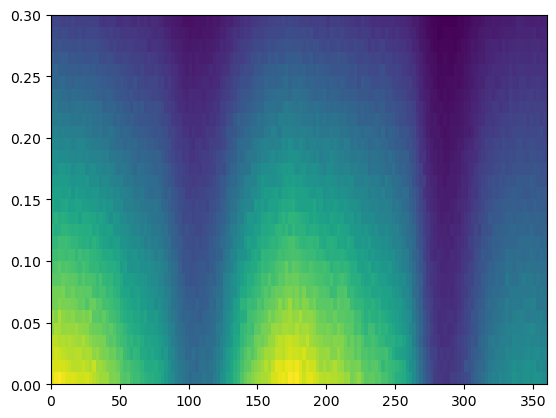

In [17]:
plt.hist2d(np.abs(sat_gr['del_lon']),np.abs(sat_gr['del_lat']),range=[[0,360],[0,0.3]],bins=[144,30])

In [18]:
gd_lon = sat_gr['del_lon'] <= 5
gd_lon.value_counts()


del_lon
False    8636848
True      990415
Name: count, dtype: int64

In [ ]:
sat_gr[gd_lon].tail(20)